Explore features created by chord_matrices notebook

In [172]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ast

In [173]:
#import cleaned dataset produced the data/data_clean script
path_to_clean_df='../../data/clean.csv'
df=pd.read_csv(path_to_clean_df)

In [174]:
#there is a single datapoint which contains a chord 'sC' which is not in the chord dictionary; drop this row
print(df[df['spotify_song_id']=='0cUssfb9LDMpEXy812iWCO'].iloc[0,1])
df=df.drop(index=238060)

<intro_1> C Emin F C G F Fsus2/E F C G F Fsus2/E C F C Emin C Emin F C G F Fsus2/E F sC G F Fsus2/E C F C Emin C Emin F C G F C G F Fsus2/E C F C Amin F C G Amin F C G Amin F C G Amin F C


In [175]:
#focus just on chords, decades and genre
df=df[['chords','main_genre','decade']]
df.shape

(477939, 3)

Use Joshua's code to edit chord strings add then chord matrices:

In [176]:
# Read the mapping CSV file
chord_relations = pd.read_csv('../data/chords_mapping.csv')

# Create a dictionary with keys the "chords" and values the "degrees"
chord_degrees = dict(zip(chord_relations['Chords'], chord_relations['Degrees']))
for key, value in chord_degrees.items():
    chord_degrees[key] = ast.literal_eval(value)

# replacing spaces with commas
def replace_space_with_comma(my_string):
    return my_string.replace(" ",",")

# replacing spaces with commons in all chords in all rows of the data
df.loc[:,'chords'] = df['chords'].apply(replace_space_with_comma)

# Remove section markers
def remove_section_markers(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '<':
            # Skip until after the following ", "
            j = my_string.find('>', i)
            if j == -1:
                break  # no closing '>', stop
            i = j + 2  # skip '>,' and the space
        else:
            result.append(my_string[i])
            i += 1
    assert('<' not in result)
    assert('>' not in result)
    return ''.join(result)

df.loc[:,'chords'] = df['chords'].apply(remove_section_markers)

# Removing inversions
def remove_inversions(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '/':
            # Skip until after the following ", "
            j = my_string.find(',', i)
            if j == -1:
                break  # no closing comma, stop
            i = j  # skip comma
        else:
            result.append(my_string[i])
            i += 1
    return ''.join(result)

df.loc[:,'chords'] = df['chords'].apply(remove_inversions)


In [177]:
list_of_chord_lists = list(df.chords)
giant_chord_string = ','.join(list_of_chord_lists)
data_set_chords = list(set(giant_chord_string.split(','))) # converting to a set as an intermediate step will get rid of duplicates
assert(len(data_set_chords) == len(set(data_set_chords))) 

known_chords = list(chord_degrees.keys())
mystery_chords = list(set(data_set_chords).difference(set(known_chords)))
assert(len(mystery_chords) == len(set(mystery_chords))) # validating no duplicates
print(len(mystery_chords))
print(mystery_chords)

0
[]


In [178]:
# function to convert a string of comma-separated chords into a matrix, where each column denotes a chord
def string_to_chord_matrix(chord_sequence):
    # split sequence over commas, ignoring any "empty string" chords
    chord_list = [c for c in chord_sequence.split(',') if c != '']
    
    # then look up each chord in chord_degrees dictionary by the key value
    return np.array([chord_degrees[c][::-1] for c in chord_list]).transpose()

df.insert(loc = 1,
                  column = 'chord_matrix',
                  value = df['chords'].apply(string_to_chord_matrix),
                  allow_duplicates = False)

In [179]:
df.head()

,chords,chord_matrix,main_genre,decade
0,"C,F,C,E7,Amin,C,F,C,G7,C,F,C,E7,Amin,C,F,G7,C,...","[[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,...",pop,NaN
1,"E,D,A,E,D,A,E,D,A,E,D,A,E,D,A,E,D,A,C,E,G,D,A,...","[[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,...",metal,2000.0
2,"Csmin,A,Csmin,A,Csmin,A,Csmin,A,B,Csmin,A,Fsmi...","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,...",metal,2000.0
3,"D,Dmaj7,D,Dmaj7,Emin,A,D,G,Emin,A,D,G,Emin,A,D...","[[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,...",NaN,2020.0
4,"C,G,C,G,C,F,Dmin,G,Dmin,G,C,G,C,F,Dmin,G,Dmin,...","[[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,...",pop,2020.0


Define Joshua's features/helper functions (with slight modifications):

In [180]:

def total_chords(chord_string):
    # count the number of total chords in a comma-separated string
    return len(chord_string.split(','))

def missing_notes(chord_matrix):
    # returns the number of notes missing, i.e. number of zero rows in the chord matrix
    count = 0
    for row in chord_matrix:
        if not row.any():
            count += 1
    return count

def note_frequency_vector(chord_matrix):
    # return a vector of note counts
    # or if relative=True, return a percentage version of this, using the number of total chords as the denominator
    count_vector = [np.sum(chord_matrix[i]) for i in range(12)]
    return count_vector[::-1] # need to reverse to get "bottom-up"

def most_common_notes(chord_matrix, names = True, spelling = 'sharp'):
    frequency_vector = note_frequency_vector(chord_matrix)
    max_frequency = np.max(frequency_vector)
    notes = []
    for i in range(12):
        if frequency_vector[i] == max_frequency:
            notes.append(i)
    return notes

def max_freq(chord_matrix):
    #for calculating drone ratio
    return np.max(note_frequency_vector(chord_matrix))

def sequential_overlap(chord_matrix):
    # a measure of how much sequential pairs of chords overlap in notes
    transposed_matrix = np.transpose(np.copy(chord_matrix))
    similarity_vector = np.zeros(shape = len(transposed_matrix) - 1, 
                                 dtype=int)
    for i in range(len(transposed_matrix) - 1):
        # look the ith row (chord), and compare with the following chord
        # take the dot product, which counts the number of overlapping notes
        similarity_vector[i] = np.dot(transposed_matrix[i],transposed_matrix[i+1])
    return list(similarity_vector)

def average_sequential_overlap(chord_matrix):
    return np.mean(sequential_overlap(chord_matrix))



In [181]:
df.insert(2,'tot_chords',df['chords'].apply(total_chords))
df.insert(3,'missing_notes',df['chord_matrix'].apply(missing_notes))
df.insert(4,'note_frequency_vec',df['chord_matrix'].apply(note_frequency_vector))
df.insert(5,'most_common_notes',df['chord_matrix'].apply(most_common_notes))
df.insert(6,'drone_ratio',df['chord_matrix'].apply(max_freq)/df['tot_chords'])
df.insert(7,'average_overlap',df['chord_matrix'].apply(average_sequential_overlap))

### Songs by Missing Notes ###

missing_notes
5     185471
4     100405
3      64061
2      44340
0      29637
1      28934
6      16144
7       7817
8       1035
9         90
10         5
Name: count, dtype: int64


Text(0.5, 0, 'Number of Missing Notes')

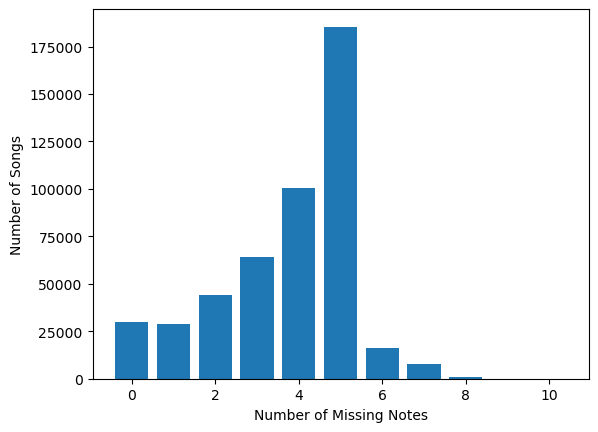

In [182]:
missing=df['missing_notes'].value_counts()
print(missing)
plt.bar(missing.index,missing)
plt.ylabel('Number of Songs')
plt.xlabel('Number of Missing Notes')

Text(0.5, 0, 'Average number of missing notes')

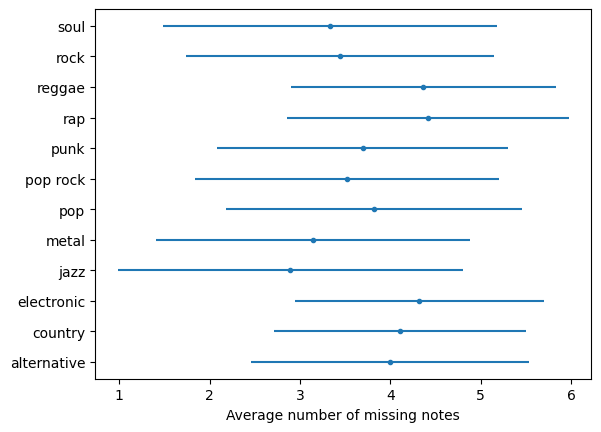

In [183]:
#average and standard deviation of missing note number by genre
genre_means=df[['missing_notes','main_genre']].groupby('main_genre').mean()
genre_std=df[['missing_notes','main_genre']].groupby('main_genre').std()
plt.errorbar(genre_means.missing_notes,genre_means.index,xerr=genre_std.missing_notes,
             ls='None',marker='.')
plt.xlabel('Average number of missing notes')

Text(0.5, 0, 'Average number of missing notes')

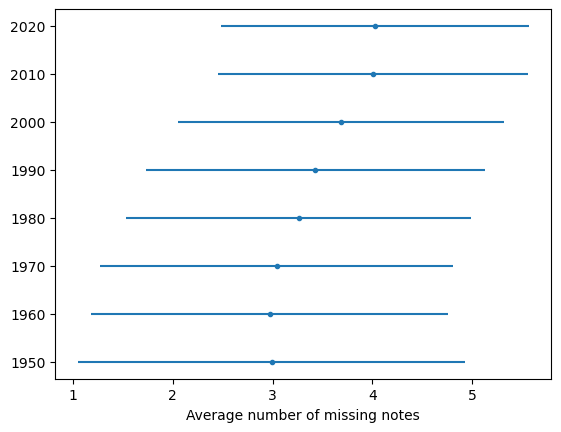

In [184]:
#average and standard deviation of missing note number by decade
genre_means=df[['missing_notes','decade']].groupby('decade').mean()
genre_std=df[['missing_notes','decade']].groupby('decade').std()
plt.errorbar(genre_means.missing_notes,genre_means.index,xerr=genre_std.missing_notes,
             ls='None',marker='.')
plt.xlabel('Average number of missing notes')

There seem to be some interesting trends, like jazz and metal having the fewest average missing notes, or average missing notes seeming to increase over time, but the standard deviations are very large; therefore this might not be useful.

### Songs by Drone Ratio ###


count    477939.000000
mean          0.694780
std           0.126111
min           0.237113
25%           0.605839
50%           0.687500
75%           0.764706
max           1.000000
Name: drone_ratio, dtype: float64


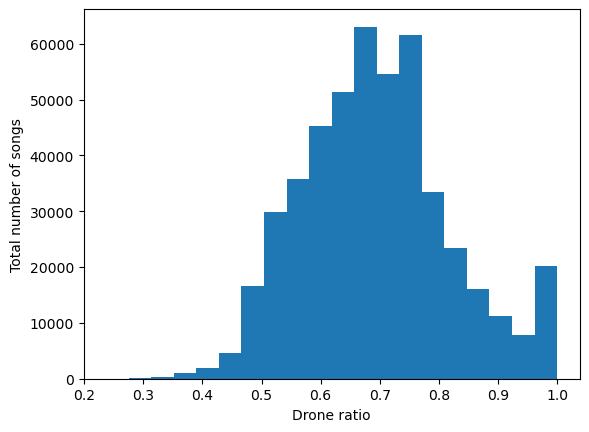

In [188]:
plt.hist(df.drone_ratio,bins=20)
print(df.drone_ratio.describe())
plt.xlabel('Drone ratio')
plt.ylabel('Total number of songs')
plt.show()

<Figure size 640x480 with 0 Axes>

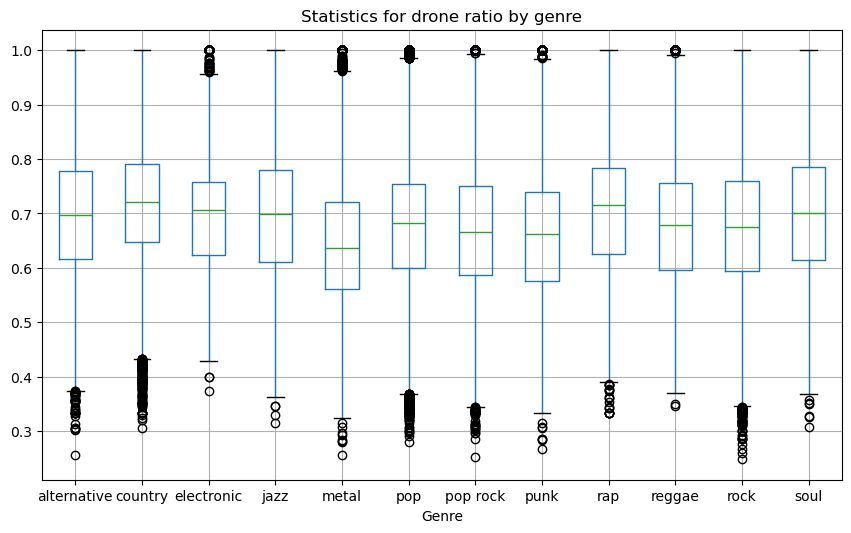

In [190]:
#box and whisker grouped by genre
plt.figure()
df.boxplot(column='drone_ratio',by='main_genre',figsize=(10,6))
plt.xlabel('Genre')
plt.suptitle('')
plt.title('Statistics for drone ratio by genre')
plt.show()

In [192]:
#mean per genre
df[['drone_ratio','main_genre']].groupby('main_genre').mean()

,drone_ratio
main_genre,
alternative,0.707170
country,0.723408
electronic,0.704834
jazz,0.700926
metal,0.647200
pop,0.689314
pop rock,0.676135
punk,0.663589
rap,0.720459


<Figure size 640x480 with 0 Axes>

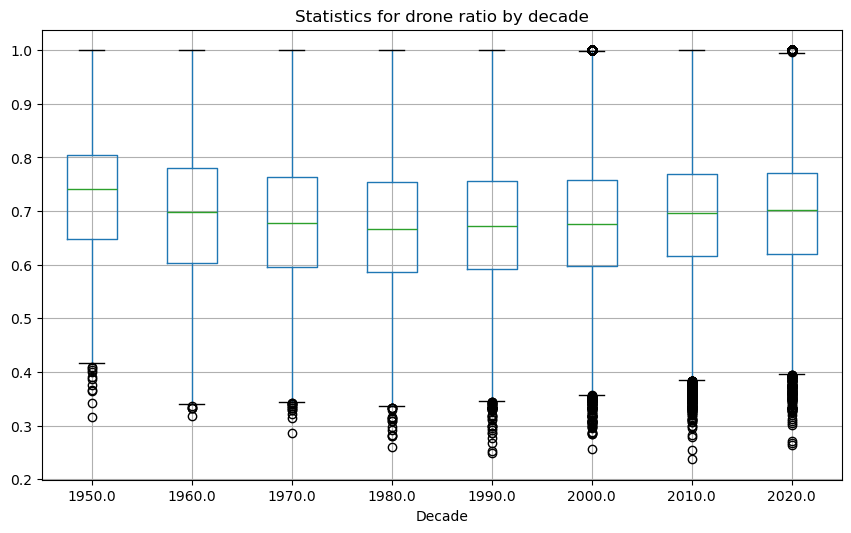

In [191]:
#box and whisker grouped by decade
plt.figure()
df.boxplot(column='drone_ratio',by='decade',figsize=(10,6))
plt.xlabel('Decade')
plt.suptitle('')
plt.title('Statistics for drone ratio by decade')
plt.show()

In [ ]:
#mean per decade
df[['drone_ratio','decade']].groupby('decade').mean()

,drone_ratio
decade,
1950.0,0.728808
1960.0,0.694342
1970.0,0.683428
1980.0,0.676380
1990.0,0.680820
2000.0,0.685231
2010.0,0.703271
2020.0,0.707304


Drone ratio is lowest for metal and highest for rap and country. Also very high in the 1950's compared to other decades.

### Songs by average overlap ###

count    477939.000000
mean          1.006704
std           0.387263
min           0.000000
25%           0.768293
50%           0.977273
75%           1.192308
max           5.842105
Name: average_overlap, dtype: float64


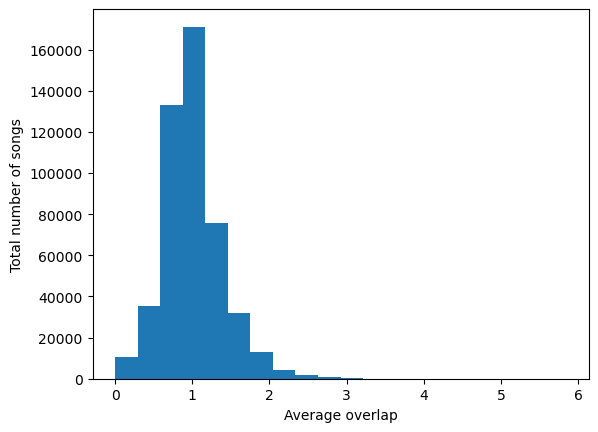

In [194]:
plt.hist(df.average_overlap,bins=20)
print(df.average_overlap.describe())
plt.xlabel('Average overlap')
plt.ylabel('Total number of songs')
plt.show()

There are 5 high outliers with average overalp > 4.5, cut these out of the following plots

<Figure size 640x480 with 0 Axes>

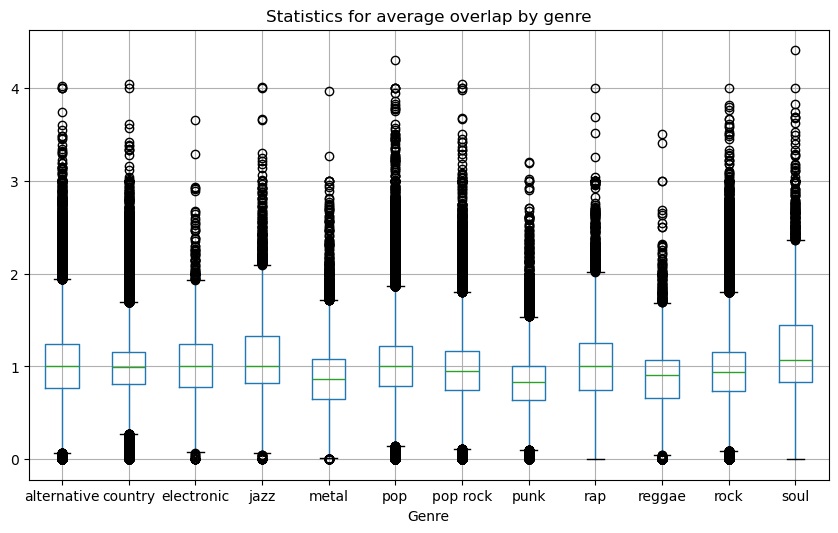

In [204]:
#box and whisker grouped by genre, ignoring high outliers
plt.figure()
df[df['average_overlap']<4.5].boxplot(column='average_overlap',by='main_genre',figsize=(10,6))
plt.xlabel('Genre')
plt.suptitle('')
plt.title('Statistics for average overlap by genre')
plt.show()

In [207]:
#mean per genre
df[['average_overlap','main_genre']].groupby('main_genre').mean()

,average_overlap
main_genre,
alternative,1.032753
country,1.011548
electronic,1.024922
jazz,1.107106
metal,0.884562
pop,1.024809
pop rock,0.985667
punk,0.844730
rap,1.041985


<Figure size 640x480 with 0 Axes>

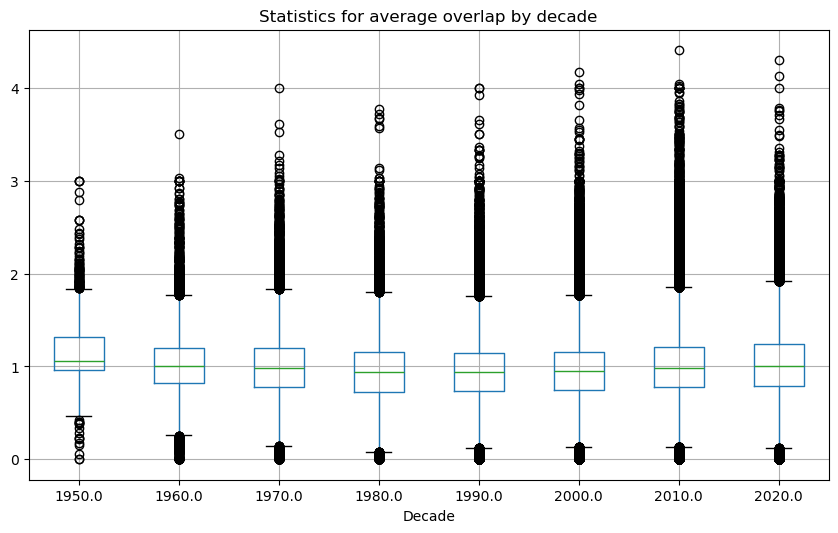

In [208]:
#box and whisker grouped by decade, ignoring high outliers
plt.figure()
df[df['average_overlap']<4.5].boxplot(column='average_overlap',by='decade',figsize=(10,6))
plt.xlabel('Decade')
plt.suptitle('')
plt.title('Statistics for average overlap by decade')
plt.show()

In [209]:
#mean per decade
df[['average_overlap','decade']].groupby('decade').mean()

,average_overlap
decade,
1950.0,1.149024
1960.0,1.031377
1970.0,1.016890
1980.0,0.970214
1990.0,0.967824
2000.0,0.973176
2010.0,1.020712
2020.0,1.048164


Soul seems to have the highest average overalp statistics while metal and punk are the lowest. The trend over time is very similar to that of the drone ratio trend.

In [189]:
def is_major_triad(chord_vector):
    # return true if chord_vector is a major triad
    C_triad = chord_degrees['C']
    for i in range(12):
        if np.array_equal(chord_vector[::-1], 
                          transpose_chord_up(C_triad,i)):
            return 1
    return 0

def major_triads(chord_string):
    # return a binary vector indicating where simple major triads occur
    return [is_major_triad(c) for c in np.transpose(string_to_chord_matrix(chord_string))]

def major_triad_ratio(chord_string):
    return np.mean(major_triads(chord_string))